#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 08
**CH08A Finding a good deal among hotels with nonlinear function**

using the hotels-vienna dataset

version 1.0 2021-05-05 (modified for TA session 04.11.2023)

### Case study

The aim of the analysis is to identify hotels that are underpriced relative to their distance to the city center. 

If the shape of the pattern is well captured by the regression, then the lowest prices are well captured by the smallest (most negative) regression residuals.

Previously: $price^E=\alpha + \beta \times distance$

We saw that this simple regression does not fully reproduce the pattern suggested by the non-parametric regression (when closer to the city center, same difference in distance is associated with larger price differences) -> $y^E=f(x)$ relationship is nonlinear

We saw that the distribution of hotel prices is skewed with a long right tail -> transform it to measure differences in relative terms, instead of dollars.



### Recap theory
**Linear regression** - **linear approximation**: $y^E = f(x) \sim \alpha + \beta x$

Potential **nonlinear shapes** matter if
- prediction
- uncovering more than the average pattern of association
- linear approximation is bad

Linear regression analysis can accomodate nonlinear patterns.

Most commonly used **transformations**:
- ***ln***
- ***piecewise linear splines***
- ***polynomials***
- ***ratios***


## Set up
- stargazer: nice regression outputs, especially useful to compare multiple regression outputs

In [2]:
import os
import sys
import warnings
!pip install stargazer
import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

warnings.filterwarnings("ignore")

# Current script folder
current_path = os.getcwd()
dirname = current_path.split("TAsessions")[0]

# location folders
data_in = dirname + "TAsessions/da_data_repo/hotels-vienna/clean/"
data_out = dirname + "TAsessions/ch08-hotels-measurement-error/"
output = dirname + "TAsessions/ch08-hotels-measurement-error/output/"
func = dirname + "TAsessions/ch00-tech-prep/"
sys.path.append(func)

# Import the prewritten helper functions
from py_helper_functions import *


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for stargazer from https://files.pythonhosted.org/packages/05/ef/bf2eb43ff3047099f3c2f502040fcca384d3b035adf38cefcca96ae6cf92/stargazer-0.0.6-py3-none-any.whl.metadata


In [3]:
# load vienna
hotels = pd.read_csv(data_in + "hotels-vienna.csv")


In [4]:
hotels = hotels.loc[
    (hotels["accommodation_type"] == "Hotel")
    & (hotels["city_actual"] == "Vienna")
    & (hotels["stars"] >= 3)
    & (hotels["stars"] <= 4)
    & (hotels["stars"].notna())
    & (hotels["price"] <= 600)
]


## LOG MODELS
Taking the natural log of a variable **approximates relative differences**: 

$\ln(x+\Delta x) - \ln(x) \approx \frac{\Delta x}{x}$

the difference between the $\ln$ of two values is approximately the relative difference between the two (for small differences, 30\% or smaller, either positive or negative)

For example: 

- if $x_2$ is 10\% larger than $x_1$, i.e. $x_2 =1.1 \times x_1$, then $\ln(x_2) -\ln(x_1) \approx 0.1 = 10\%$
- if $x_2$ is 10\% smaller than $x_1$, i.e. $x_2 =0.9 \times x_1$, then $\ln(x_2) -\ln(x_1) \approx -0.1 = -10\%$

-> log transformation allows for comparison in relative terms - percentages

**Note**: only possible for values >0

**WHEN?**: when comparison makes more sense in relative terms (percentage differences)

examples: prices, sales, GDP, population, employment, capital stock ...

(if, for example, an hotel costs 200€ per night, this might not say much if we do not care about the magnitude but we alre only interested in finding "best deal" -> we need to compare this price to the prices of the other hotels)


##### Interpreting parameters

- log-log regression: $(\ln y)^E =\alpha +\beta \ln x$ -> $y$ is $\beta$\% higher, on average, for observations having 1\% higher $x$

- log-level regression: $(\ln y)^E =\alpha +\beta x$ -> $y$ is $\beta\times 100$\% higher, on average, for observations having 1 unit higher $x$

- level-log regression: $(y)^E =\alpha +\beta \ln x$ -> $y$ is $\frac{\beta}{100}$ units higher, on average, for observations having 1\% higher $x$

**Log transformation**: prices and distances

In [5]:
hotels["lnprice"] = np.log(hotels["price"])
hotels["distance2"] = hotels["distance"]
hotels.loc[hotels["distance2"] < 0.05, "distance2"] = 0.05
#distance is rounded to 0.1 miles for one hotel with 0 distance. Replace with 0.05
hotels["lndistance"] = np.log(hotels["distance2"])

In [6]:
hotels["price"].describe()


count    207.000000
mean     109.975845
std       42.221381
min       50.000000
25%       82.000000
50%      100.000000
75%      129.500000
max      383.000000
Name: price, dtype: float64

In [8]:
hotels["lnprice"].describe()


count    207.000000
mean       4.640219
std        0.336751
min        3.912023
25%        4.406719
50%        4.605170
75%        4.863673
max        5.948035
Name: lnprice, dtype: float64

The average price is 110 US dollars; $\ln(110)=4.7$, slightly more than the average prie of $\ln(price)$

Distribution of $\ln price$ is rather symmetric, unlike the distribution of price:

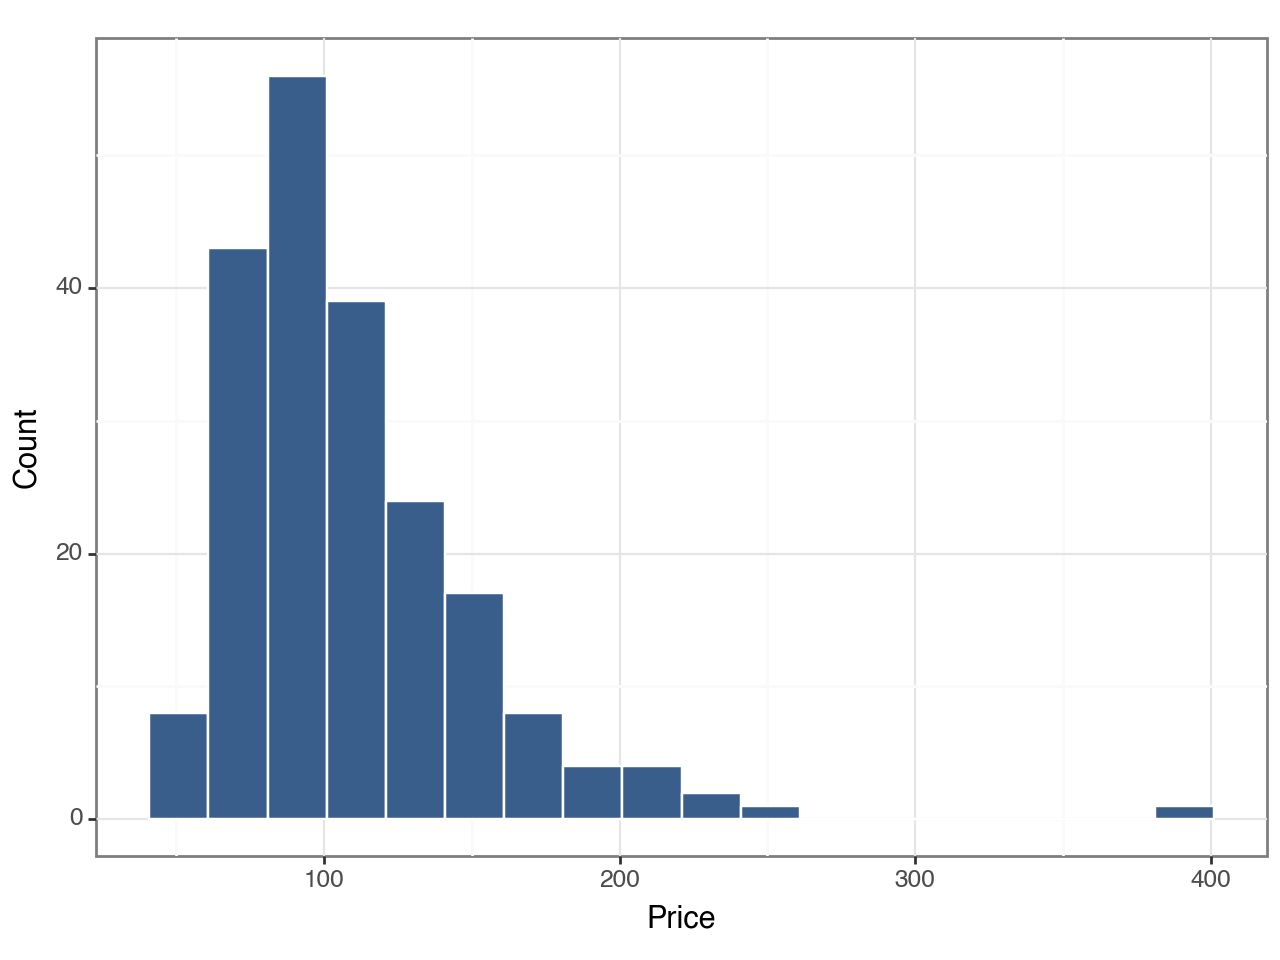

<Figure Size: (640 x 480)>

In [20]:
#extra
(
    ggplot(hotels, aes(x="price"))
    + geom_histogram(
        aes(y="..count.."),
        binwidth=20,
        boundary=1,
        fill=color[0],
        color="white",
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Price", y="Count")
    + theme_bw()
)

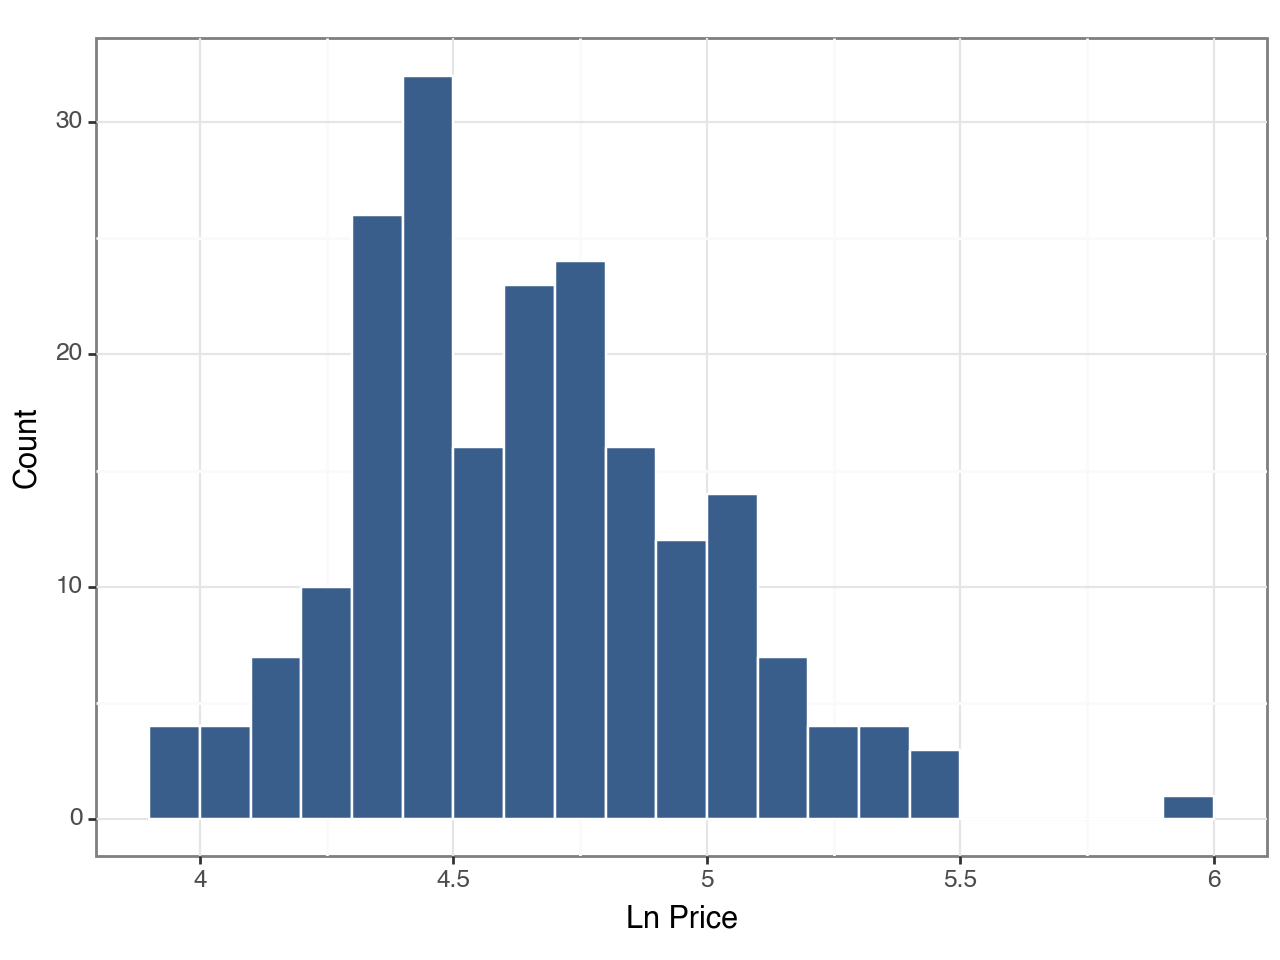

<Figure Size: (640 x 480)>

In [27]:
#extra
(
    ggplot(hotels, aes(x="lnprice"))
    + geom_histogram(
        aes(y="..count.."),
        binwidth=0.1,
        boundary=1,
        fill=color[0],
        color="white",
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Ln Price", y="Count")
    + theme_bw()
)

Distribution closer to normal

## Regression

We compare the simple linear regressions: 
- level-level
- level-log
- log-level
- log-log

In [28]:
reg1 = smf.ols("price ~ distance", data=hotels).fit()
reg1.summary()
#same as before


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     38.20
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           3.39e-09
Time:                        17:55:03   Log-Likelihood:                -1050.3
No. Observations:                 207   AIC:                             2105.
Df Residuals:                     205   BIC:                             2111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.0170      4.474     29.511      0.000     123.197     140.837
distance     -14.4064      2.331     -6.181      0.000     -19.002      -9.811
==============================================================================
Omnibus:                      141.994   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.025
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      15.488   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
reg2 = smf.ols("price ~ lndistance", data=hotels).fit()
reg2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     79.58
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           2.61e-16
Time:                        16:22:33   Log-Likelihood:                -1034.1
No. Observations:                 207   AIC:                             2072.
Df Residuals:                     205   BIC:                             2079.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.4171      2.512     44.757      0.000     107.465     117.369
lndistance   -24.7683      2.777     -8.921      0.000     -30.243     -19.294
==============================================================================
Omnibus:                      175.079   Durbin-Watson:                   1.612
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3501.545
Skew:                           3.084   Prob(JB):                         0.00
Kurtosis:                      22.182   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**:
intercept 112 (at center, cost 112 on average); hotels that are 10\% (1\%) farther away from center are 2.5 (25) dollars less expensive, on average

In [11]:
reg3 = smf.ols("lnprice ~ distance", data=hotels).fit()
reg3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     52.90
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           7.30e-12
Time:                        16:22:36   Log-Likelihood:                -44.160
No. Observations:                 207   AIC:                             92.32
Df Residuals:                     205   BIC:                             98.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8411      0.035    139.720      0.000       4.773       4.909
distance      -0.1313      0.018     -7.273      0.000      -0.167      -0.096
==============================================================================
Omnibus:                       28.470   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.450
Skew:                           0.746   Prob(JB):                     4.97e-11
Kurtosis:                       4.809   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**note**: The $R^2$ is higher (0.21 vs 0.16). However, we are comparing the regressions with different dependent variables: it is "unfair" as it compares fit in different units -> avoid this comparison

**Interpretation**:

reg1: intercept 133; hotels that are 1 mile farther away from center are 14 dollars less expensive, on average

reg2: intercept 4.84; hotels that are 1 mile farther away from center are 13\% less expensive, on avergae

In [12]:
reg4 = smf.ols("lnprice ~ lndistance", data=hotels).fit()
reg4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     102.6
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           8.18e-20
Time:                        16:22:38   Log-Likelihood:                -25.911
No. Observations:                 207   AIC:                             55.82
Df Residuals:                     205   BIC:                             62.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6615      0.019    241.926      0.000       4.623       4.699
lndistance    -0.2158      0.021    -10.130      0.000      -0.258      -0.174
==============================================================================
Omnibus:                       47.573   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.794
Skew:                           0.976   Prob(JB):                     1.08e-28
Kurtosis:                       6.335   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**:
Intercept 4.66; hotels that are 1\% farther away from center are 0.22\% less expensive, on average.

### Figure 8.1 Regressions of hotel price and distance to the city center

We compare level-level and log-level scatterplots

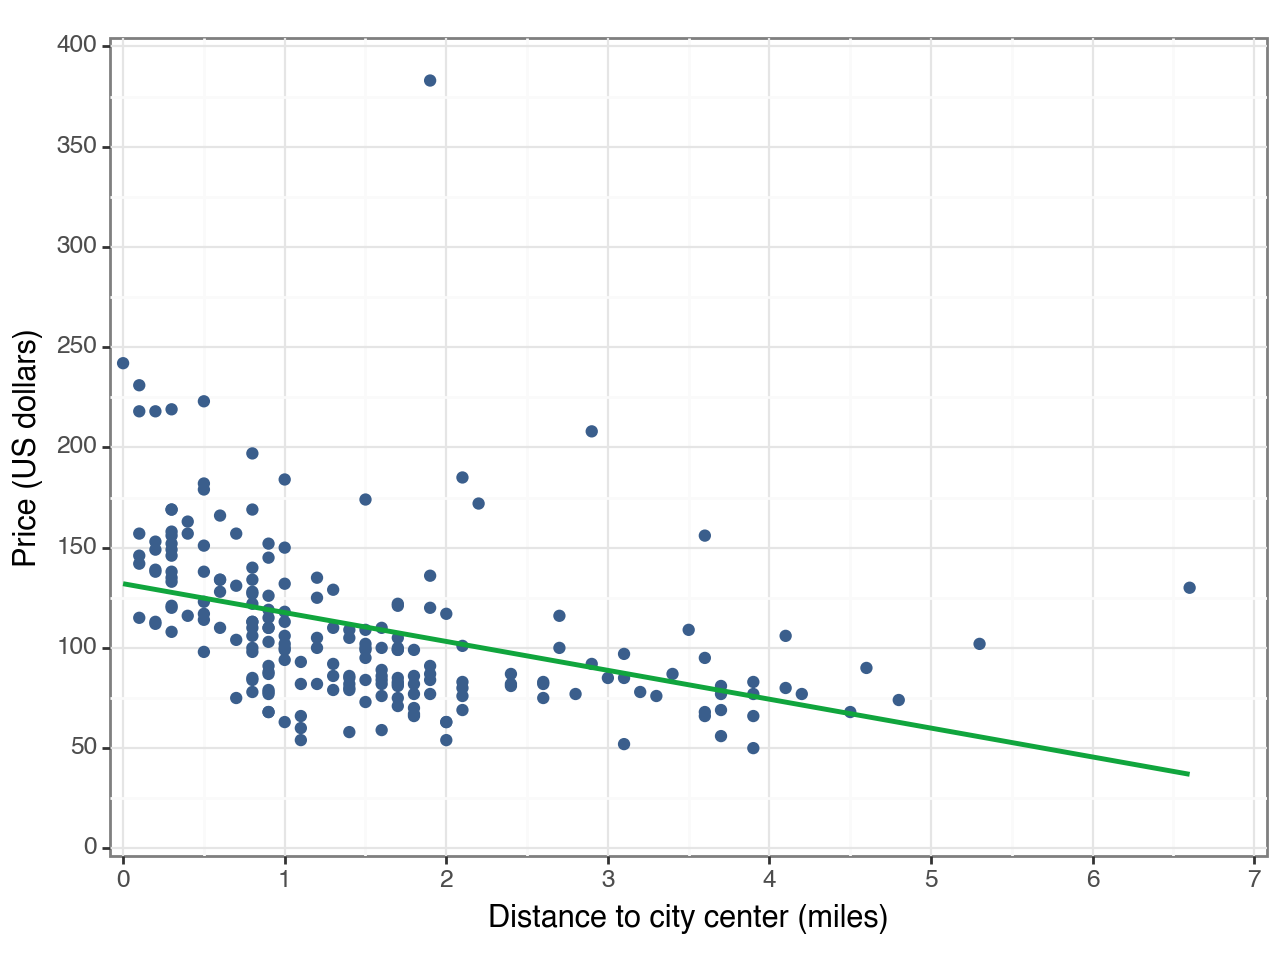

<Figure Size: (640 x 480)>

In [13]:
(
    ggplot(hotels, aes(x="distance", y="price"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", color=color[1], se=False)
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 7], breaks=seq(0, 8, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50))
    + labs(x="Distance to city center (miles)", y="Price (US dollars)")
    + theme_bw()
)


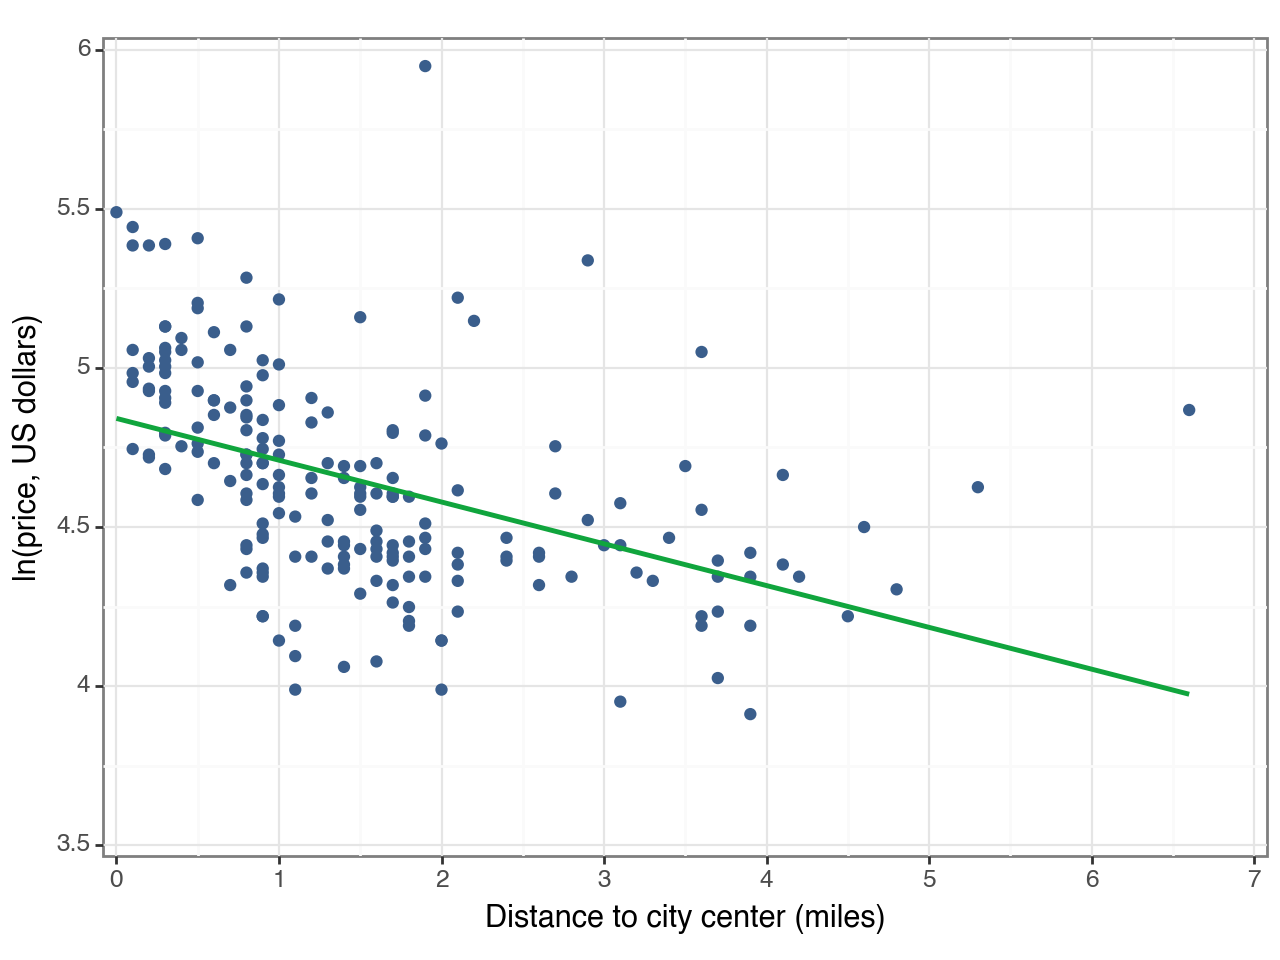

<Figure Size: (640 x 480)>

In [14]:
(
    ggplot(hotels, aes(x="distance", y="lnprice"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", color=color[1], se=False)
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 7], breaks=seq(0, 8, 1))
    + scale_y_continuous(
        expand=[0.01, 0.01], limits=[3.5, 6], breaks=seq(3.5, 6, 0.5)
    )
    + labs(x="Distance to city center (miles)", y="ln(price, US dollars)")
    + theme_bw()
)


It seems that the scatterplot for log-level is **more symmetrically distributed around the regression line** -> log-level gives a better approximation to the average slope of the pattern (due to distribution of log prices being closer to normal)

However, the log-level still does not capture the nonlinear patter: from the scatterplot, it can be seen that the negative log price - distance association is steeper at lower levels of distance.

### Figure 8.2 Regressions of hotel price and distance to the city center

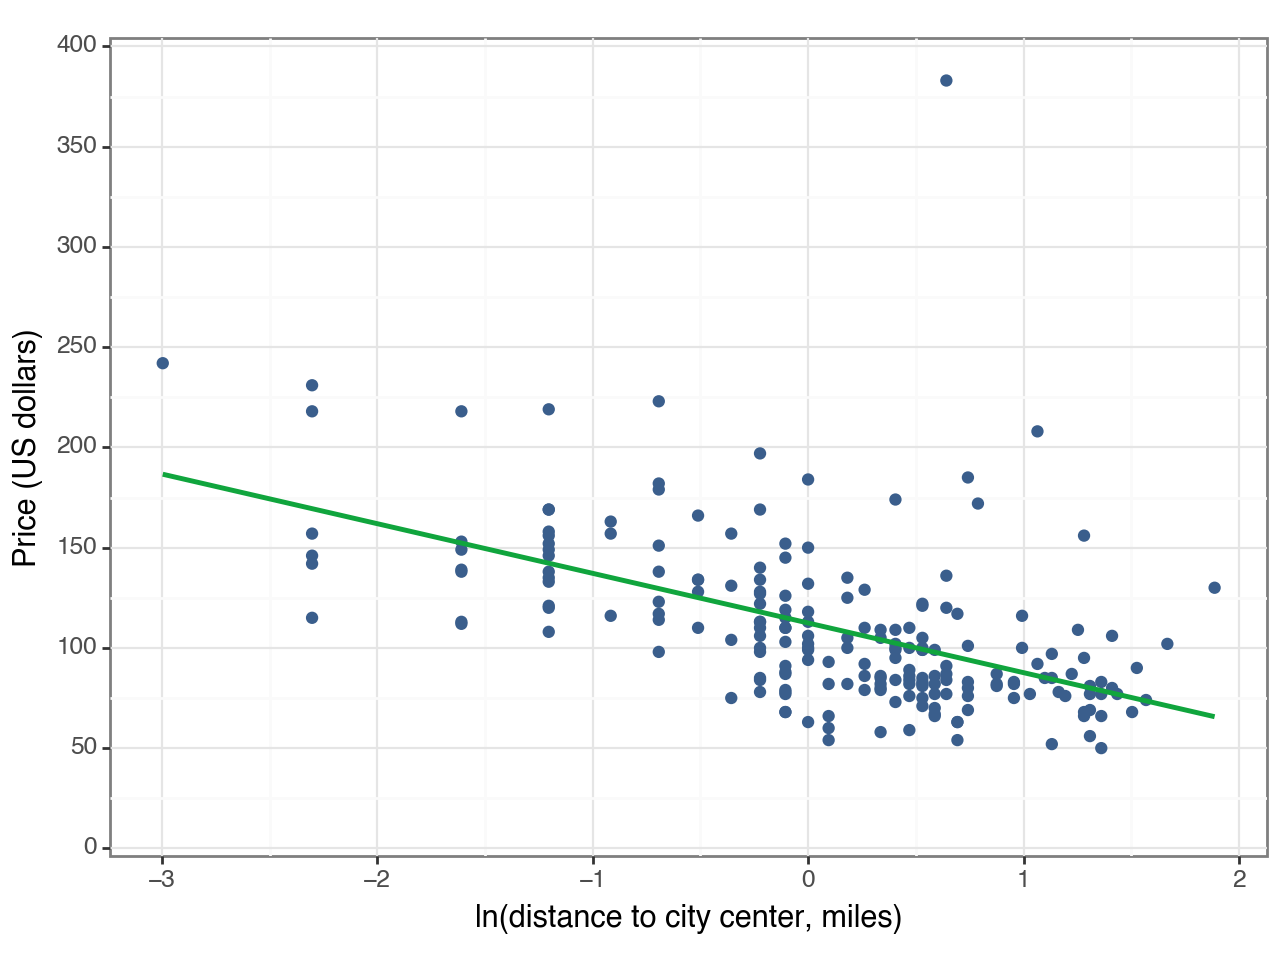

<Figure Size: (640 x 480)>

In [15]:
(
    ggplot(hotels, aes(x="lndistance", y="price"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", color=color[1], se=False)
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 400], breaks=seq(0, 400, 50))
    + labs(x="ln(distance to city center, miles)", y="Price (US dollars)")
    + theme_bw()
)


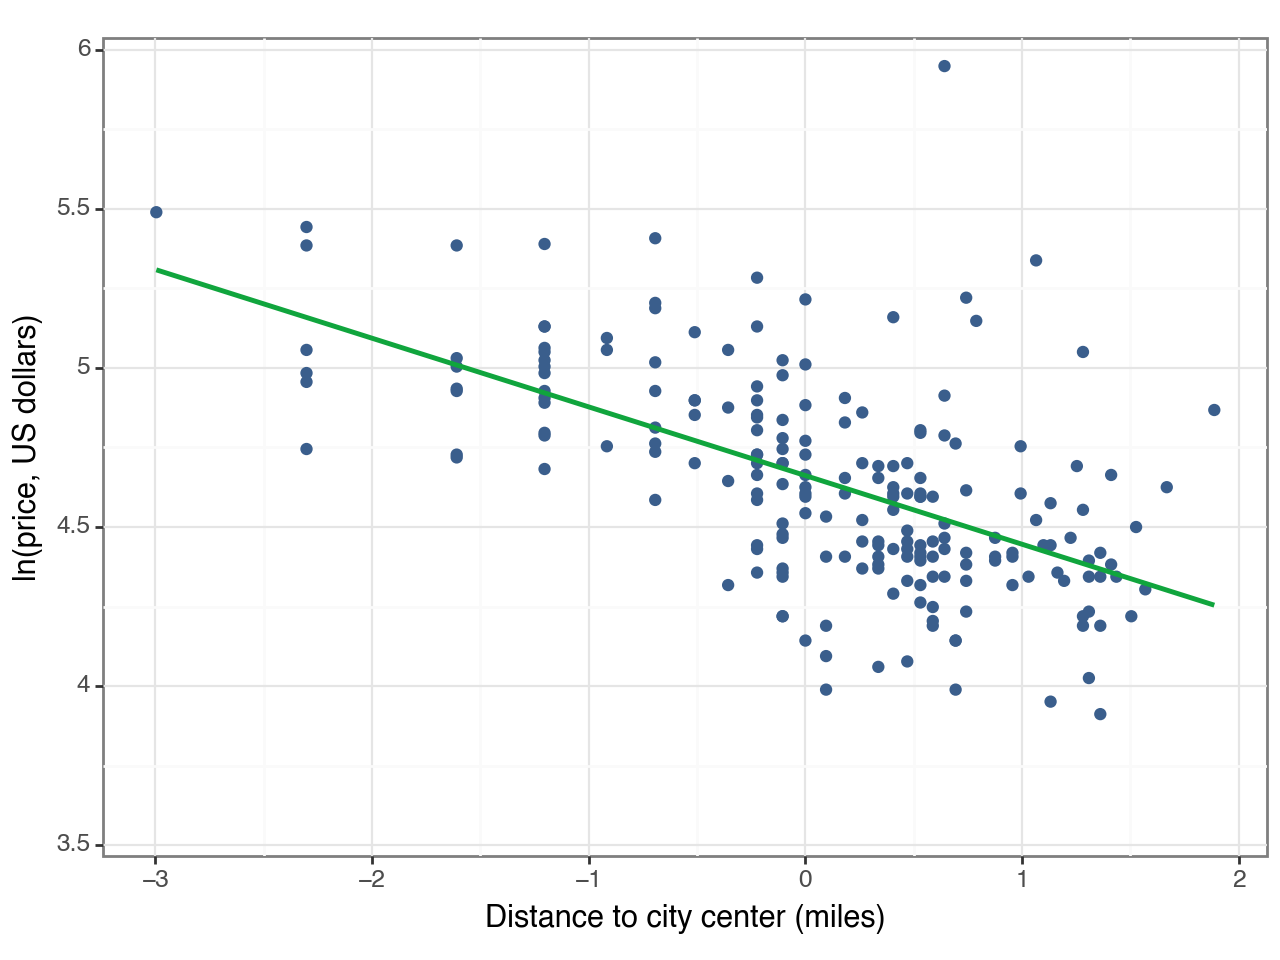

<Figure Size: (640 x 480)>

In [16]:
(
    ggplot(hotels, aes(x="lndistance", y="lnprice"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", color=color[1], se=False)
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(
        expand=[0.01, 0.01], limits=[3.5, 6], breaks=seq(3.5, 6, 0.5)
    )
    + labs(x="Distance to city center (miles)", y="ln(price, US dollars)")
    + theme_bw()
)


Compare these regressions:

In [17]:
stargazer = Stargazer([reg1, reg3, reg2, reg4])
stargazer.covariate_order(["distance", "lndistance", "Intercept"])
stargazer.custom_columns(["price", "ln(price)", "price", "ln(price)"], [1, 1, 1, 1])
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "distance": "Distance to city center, miles",
        "lndistance": "ln(distance to city center)",
    }
)
stargazer


Which one to use? your call

We might prefer log-level:
- having log price for better interpretation (we look for best deal, less interested in magnitude) and skewed distribution
- having level distance is better for interpretation (makes more sense in miles to find relatively cheap hotel)